# Обучение без учителя

## Разделение смеси распределений. EM-алгоритм
Смесь распределений задается плотностью 
$$
    p(x) = \sum\limits_{i=1}^k w_i p(x, \theta_i),
$$
где $w_i\geqslant 0$  и $\sum\limits_{i=1}^k = 1$, а $p(x, \theta_i)$ — некоторая функция плотности.

Другими словами, сначала выбирается компонента ($i$-ая компонента выбирается с вероятностью $w_i$),
а затем из соответсвующей ей плотности выбирается точка.


**Задача**: зная несколько точек, число $k$ и функцию $p(x, \theta)$ восстановить $\theta_i$

<AxesSubplot: ylabel='Density'>

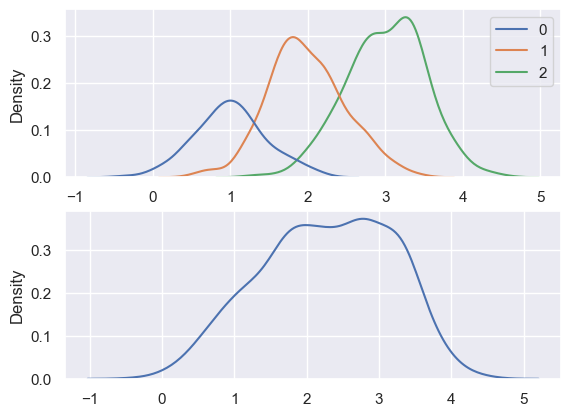

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()


sizes = [200, 400, 500]
mus = [1, 2, 3]
stds = [0.5, 0.5, 0.5]

xs = [
    mu + np.random.randn(size) * std
    for size, mu, std in zip(sizes, mus, stds)
]

merged = np.hstack(xs)

fig, ax = plt.subplots(2, 1)
sns.kdeplot(xs, ax=ax[0])
sns.kdeplot(merged, ax=ax[1])

### EM-алгоритм

Давайте введем *скрытые* (или *латентные*) переменные таким образом, чтобы зависимость стала проще.
Например, в случае разделения смеси для каждой точки $x_i$ можно ввести скрытые переменные $z_{ij}$,
которая отвечает за вероятность того, что точка $x_i$ пришла из $j$-ой компоненты.

Тогда $p(x_i) = \sum\limits_{j=1}^k z_{ij} p(x, \theta_j)$ по формуле полной вероятности.



Мы хотим максимизировать правдоподобие выборки
$$
    \log p(X | \theta) \to\max_{\theta}
$$

Пусть на скрытых переменных задано некоторое  распределение $q(Z)$.

Также будем предполагать что у нас некотрое априорное распределение на искомые параметры $p(\theta)$.

Преобразуем 
$$
    \log p(X | \theta) = [\mbox{домножим на } 1 = \int{q(Z)dZ}] \\
    = \log p(X| \theta) \int q(Z)dZ = \int q(z) \log p(X| \theta)dZ \quad (*)
$$

Применим формулу условной вероятности три раза
$$
    p(X, Z | \theta) = \frac{p(X, Z, \theta)}{p(\theta)} \\
    p(Z|X, \theta) = \frac{p(X, Z, \theta)}{p(\theta, X)} = \frac{p(X, Z, \theta)}{p(X|\theta)p(\theta)}
$$

и поделим одно на другое
$$
    p(X | \theta) = \frac{p(X, Z|\theta)}{p(Z|X, \theta)}.
$$

Возращаемся к правдоподобию

$$
    \log p(X | \theta) = \int q(Z)) \log p(X| \theta)dZ = \int q(Z) \log \frac{p(X, Z|\theta)}{p(Z|X, \theta)}dZ = \\
   =  \int q(Z)\log \frac{p(X, Z|\theta)q(Z)}{p(Z|X, \theta)q(Z)}dZ = \\
   = \int q(Z)\log \frac{p(X, Z|\theta)}{q(Z)}dZ + \int q(Z)\log \frac{q(Z)}{p(Z|X, \theta)} dZ.
$$

Второе слагаемое — это диергенция Кульбака-Лейбнера между распределениями $q(Z)$ и $p(Z|X, \theta):$

$$
    D_{KL}(Q || P) = \int q(x)\log\frac{q(x)}{p(x)}dx.
$$

Следовательно, 

$$
    \log p(X | \theta) \geqslant \int q(Z)\log \frac{p(X, Z|\theta)}{q(Z)}dZ = \mathcal{L}(q, \theta).
$$

Правая часть этого неравенства называется *нижней границей обосновованности (ELBO, evidence lower bound)*.

EM-алгоритм минимизирует $\mathcal{L}(q, \theta)$ по переменным $\theta$ и по всем распределниям $q$.

* **E-step** Оптимизируем по $q$ при фиксированных $\theta$.
* **M-step** Оптимизируем по $\theta$ при фиксированных $q$.

    $$
        \int q(Z)\log \frac{p(X, Z|\theta)}{q(Z)}dZ = \int q(Z)\log p(X, Z | \theta)dZ - \int q(Z)\log q(Z)dZ \to \max_{\theta},
    $$
    
    что эквивалентно 
    $$\int q(Z)\log p(X, Z | \theta)dZ \to\max_{\theta}$$
    
    
### Как сделать E-step?
Заметим, что (\*) не зависит от $q$, а значит, максимизация $\mathcal{L}(q, \theta)$ эквивалентна минимизации второго слагаемого в формуле, то есть дивергенции Кульбака-Лейбнера. 
Известно, что дивергенция Кульбака-Лейбнера равна 0 тогда и только тогда, когда распределения совпадают (почти всюду). 
А значит, оптимальное решение на $E$-шаге задается формулой 

$$
    q(Z) = p(Z|X, \theta).
$$

### Применение EM-алгоритма
1) Разделение смесей
2) При обработке ответов в Crowd-source используется модель Dawid-Skene для агрегации ответов ассесоров, позволяющая учитывать, что различные ассеросы допускают различные ошибки в различных заданиях. Для оценки параметров модели используется EM-агоритм
3) В кластериции алгоритм K-Means может быть рассмотрен как частный случай EM-алгоритма.

### Вернемся к разделению смесей

In [2]:
from sklearn.mixture import GaussianMixture as GMM

model = GMM(n_components=3, max_iter=100000)
model.fit(merged.reshape(-1, 1))

print(model.means_[:, 0])
print(model.covariances_[:, 0, 0])

[2.06235521 3.12398757 1.06918256]
[0.16895096 0.183958   0.21162974]


## Кластеризация
Задача кластеризация — обнаружение похожих друг на друга объектов, в случае когда разметка может отсуствовать.

## Метрики кластеризации

### Основанные на разметке
Если для объектов все-таки известны истинные метки классов, то их можно использовать для измерения качества кластеризации

#### BCubed-метрики
Средняя полнота, средняя точность и средняя $F$-мера.

Обозначения:
* $C$ — истинные метки
* $K$ — метки классов, от кластеризации

Энтропия класса:
$$
    H(C) = -\sum\limits_{c=1}^{|C|}\frac{n_c}{n}\log \frac{n_c}{n}
$$

Условная энтропия 
$$
    H(K | C) = - \sum\limits_{c=1}^{|C|}\sum\limits_{k=1}^{|K|} \frac{n_{c,k}}{n}\log\frac{n_c}{n}
$$


#### Гомогенность
$$
    h = 1 - \frac{H(C|K)}{H(C)}
$$

#### Полнота
$$
    c = 1 - \frac{H(K|C)}{H(K)}
$$


#### $v$-score
Среднее гармоническое между гомогенностью и полнотой

### Метрики без использования разметки
#### Силует (Silhouette Coefficient)

Для каждого примера вычислим два числа:
$a$ — среднее расстояние между примером и всеми остальными примерами в этом же классе
$b$ — среднее расстояние между примером и примерами из ближайшего другого класса.

и положим значение 
$$
    s = \frac{b-a}{\max(a, b)}
$$

<Figure size 640x480 with 0 Axes>

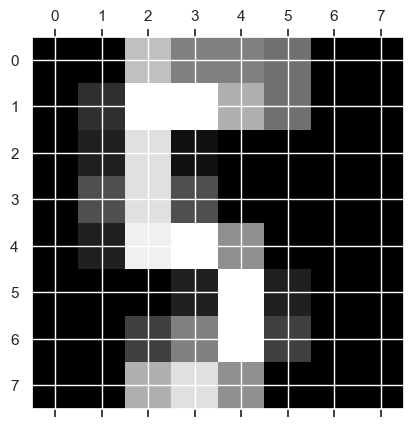

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
plt.gray()
plt.matshow(digits.images[25])
plt.show()

### KMeans
Пусть $\mu_1, \mu_2, \ldots, \mu_k$ —  центры масс кластеров. Будем их обучать.
Есть несколько способов, но мы рассмотрим два.

#### Метод Ллойда
Пусть первые $k$ объектов размечены.

1. Инициализируем начальные веса $\mu_a$.
2. Каждый объект относим к ближайшему классу: $a_i = argmin_l ||x_i - mu_l||, i = k+ 1, \ldots n$
3. Пересчитываем центры масс: $\mu_a = \frac{\sum\limits_{i=1}^n [a_i = a]x_i}{\sum\limits_{i=1}^n [a_i = a]}$
4. Повторяем пока $a_i$ меняются

#### EM-алгоритм
Примением EM-алогоритм к гауссовой смеси распределений.


#### Особенности
1. Предполагает сферическую форму кластеров
2. Чувствителен к начальному приближению
3. Медленный, используете `kmeans++`
1. Требует наперед заданного числа кластеров


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=10)
predicted = kmeans.fit_predict(digits.images.reshape(digits.images.shape[0], -1))

print(silhouette_score(digits.images.reshape(digits.images.shape[0], -1), predicted))


kmeans = KMeans(n_clusters=15)
predicted = kmeans.fit_predict(digits.images.reshape(digits.images.shape[0], -1))

print(silhouette_score(digits.images.reshape(digits.images.shape[0], -1), predicted))

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.18253439466048152


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.18657515547494463


А если уменьшить размерность?

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_transformed = tsne.fit_transform(digits.images.reshape(digits.images.shape[0], -1))

kmeans = KMeans(n_clusters=10)
predicted = kmeans.fit_predict(x_transformed)

silhouette_score(x_transformed, predicted)

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.64240557

### DBScan
Объект $x\in U$, и его $\varepsilon$-окресность $U_{\varepsilon}(x) = \{u\in U: \rho(x, u) < \varepsilon \}.$
Каждый объект может быть одного из трех видов:
* корневой, в его окрестности много элементов, $|U_{\varepsilon}(x)| \geqslant m$
* граничный, не корневой, но в окрестности корневого
* шумовой, все остальные

#### Алгоритм
* Пока есть непомеченные объекты
    1. Выбираем случайный объект
    2. Если у него в окрестности меньше $m$ объектов, то помечаем его как потенциально шумовой
    3. Если у него в окрестности по крайней мере $m$ объектов, то
        1. Образуем из его $\varepsilon$-окрестности новый кластер, помечаем все объекты
        2. Если в этой окрестности уже были помеченные объекты, то объединяем кластера
        
        
#### Особенности
1. Достаточно быстрый
1. Не требуем начального задания числа кластеров
1. Может находить кластеры произвольной формы
1. Нужно выбирать $\varepsilon$ (`eps` в scikit-learn) и $m$ (`min_samples` в scikit-learn)

Авторы статьи предлагают следующий вариант:
1) Зафиксируем какое-нибудь $m$, обычно от 3 до 9.
2) Для каждой точки вычислим расстояние до ее $m$-ого по удаленности соседа
3) Упорядочим эти расстояние и найдем точку, в которой начиается резкий рост

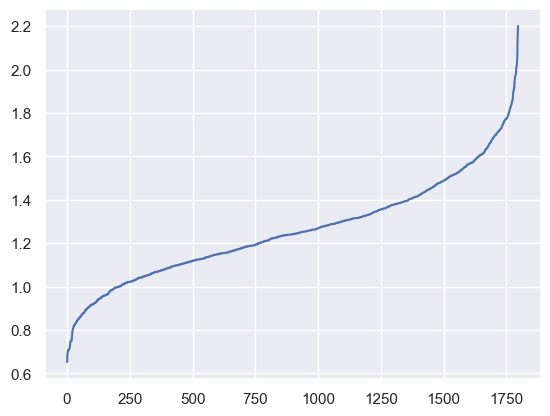

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

data = digits.images.reshape(digits.images.shape[0], -1) / 16
nn = NearestNeighbors(n_neighbors=5).fit(data)

distances, neighbors = nn.kneighbors(data, n_neighbors=5, return_distance=True)
plt.plot(np.sort(distances[:, -1]))



0.26682645143114336


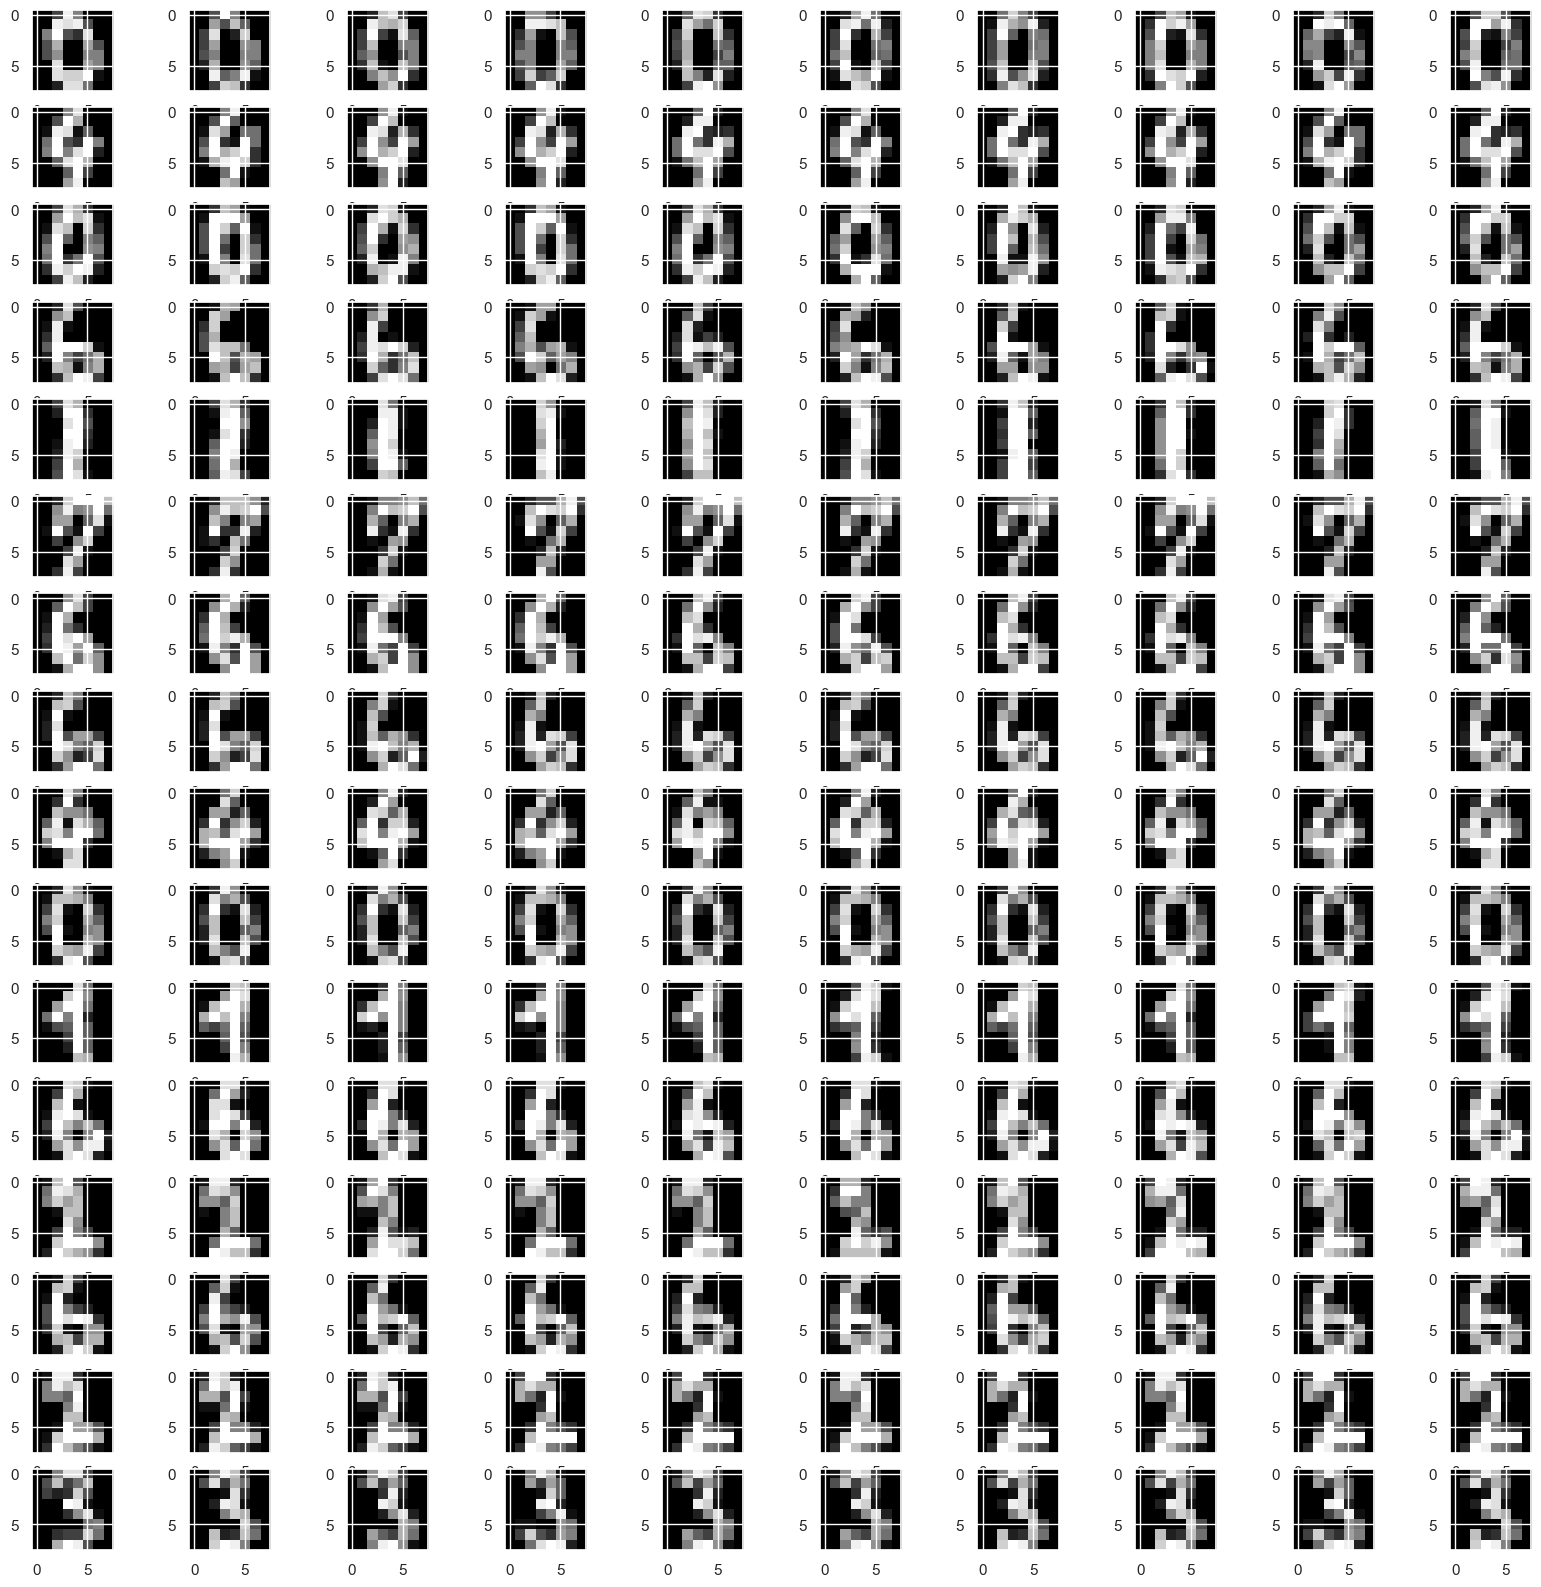

In [9]:
predicted = DBSCAN(eps=0.9, min_samples=5).fit_predict(data)
unique = np.unique(predicted[predicted != -1])

print(silhouette_score(data[predicted != -1], predicted[predicted != -1]))

sample_size = 10

fig, axes = plt.subplots(len(unique), sample_size, figsize=(20, 20))
for ind, u in enumerate(unique):
    mask = predicted == u
    images = digits.images[mask]
    indices = np.random.choice(range(len(images)), sample_size)
    for j, i in enumerate(indices):
        axes[ind][j].imshow(images[i])

### Иерархическая (агломеративная) Кластеризация
1. Изначально все объекты образуют свои собственные кластеры
2. Объедияняем кластера до тех пор, пока расстояния между ними меньше чем порог

#### Расстояние между кластерами
1. Минимальное расстояние между точками из разных кластеров
2. Максимальное расстояние между точками из разных кластеров
3. Среднеквадратичное расстояние между точками из разных кластеров

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=10)
predicted = agg.fit_predict(data)
print(silhouette_score(data, predicted))

0.17849659940596496


### Ссылки
1. [Лекция](http://www.machinelearning.ru/wiki/images/e/ed/Voron-ML-Bayes.pdf) К.В. Воронцова про баесовые методы
1. E.Amigó et at. A comparison of Extrinsic Clustering Evaluation Metrics based on Formal Constraints http://nlp.uned.es/docs/amigo2007a.pdf
1. A. Philip Dawid and Allan M. Skene. Maximum Likelihood Estimation of Observer Error-Rates Using the EM Algorithm. Journal of the Royal Statistical Society. Series C (Applied Statistics), Vol. 28, 1 (1979), 20–28. https://doi.org/10.2307/2346806
1. Ester, Kriegel, Sander, Xu. A density-based algorithm for discovering clusters in large spatial databases with noise. KDD-1996. https://cdn.aaai.org/KDD/1996/KDD96-037.pdf